# Storm Data Prediciton
## Group 1: Dhairya Dodia, Duncan Conley, Jameson Thomas
----------------------------------------------------------

### Step 0: Import libraries:

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

### Step 1: Load & Prep Data

In [108]:
file_path = "StormEvents_details-ftp_v1.0_d2024_c20250401.csv.gz"  # data

# Read the CSV file
df = pd.read_csv(file_path)

### --- FEATURE ENGINEER COLUMNS --- ###

# Combine BEGIN_LAT and END_LAT into a single LAT column
def combine_latitudes(row):
    if pd.notna(row['BEGIN_LAT']) and pd.notna(row['END_LAT']):
        return (row['BEGIN_LAT'] + row['END_LAT']) / 2  # LAT = Average (both present)
    elif pd.notna(row['BEGIN_LAT']):
        return row['BEGIN_LAT']  # LAT = BEGIN_LAT (END_LAT missing)
    elif pd.notna(row['END_LAT']):
        return row['END_LAT']  # LAT = END_LAT (BEGIN_LAT missing)
    else:
        return np.nan  # Return NaN (both missing)

# Combine BEGIN_LON and END_LON into a single LON column
def combine_longitudes(row):
    if pd.notna(row['BEGIN_LON']) and pd.notna(row['END_LON']):
        return (row['BEGIN_LON'] + row['END_LON']) / 2  # LON = Average (both present)
    elif pd.notna(row['BEGIN_LON']):
        return row['BEGIN_LON']  # LON = BEGIN_LON (END_LON missing)
    elif pd.notna(row['END_LON']):
        return row['END_LON']  # LON = END_LON (BEGIN_LON missing)
    else:
        return np.nan  # Return NaN (both missing)

# Combine BEGIN_DATE_TIME and END_DATE_TIME into a single ELAPSED_TIME_MIN column
def calculate_elapsed_minutes(row):
    # Convert the strings to datetime objects using the correct format
    begin_time = pd.to_datetime(row['BEGIN_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    end_time = pd.to_datetime(row['END_DATE_TIME'], format="%d-%b-%y %H:%M:%S", errors='coerce')
    
    # If either conversion fails, return NaN
    if pd.isna(begin_time) or pd.isna(end_time):
        return np.nan

    # Compute the elapsed time in minutes and return as an integer
    elapsed = end_time - begin_time
    return int(elapsed.total_seconds() // 60)

def convert_damage(value):
    if pd.isna(value):
        return 0  # Handle NaN values
    value = str(value).upper().strip()  # Ensure the value is uppercase and clean
    if value.endswith('K'):  # Thousands
        try:
            return float(value[:-1]) * 1e3
        except ValueError:
            return 0
    # Optionally, handle other cases (e.g., values ending in 'M' for millions)
    try:
        return float(value)
    except ValueError:
        return 0

# Drop all rows in which there is no DAMAGE_PROPERTY
df = df[pd.notna(df['DAMAGE_PROPERTY'])]

# Convert damage values to numeric
df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].apply(convert_damage)
df['DAMAGE_CROPS'] = df['DAMAGE_CROPS'].apply(convert_damage)
df['DAMAGE_PROPERTY'] = pd.to_numeric(df['DAMAGE_PROPERTY'], errors='coerce')

# Create new columns from longitudes, latitudes, and elapsed time
df['LAT'] = df.apply(combine_latitudes, axis=1)
df['LON'] = df.apply(combine_longitudes, axis=1)
df['ELAPSED_TIME_MIN'] = df.apply(calculate_elapsed_minutes, axis=1)


# Keep only rows where 'EVENT_TYPE' is 'Tornado'
df = df[df['EVENT_TYPE'] == 'Tornado']

# Verify the result
print(df['EVENT_TYPE'].unique())
print(f"Number of rows after filtering: {len(df)}")

# Drop unnecessary columns
df = df.drop(columns=['EVENT_TYPE'])

# Verify the result
#print(df.columns)
df = df.drop(columns=[
    'CZ_TYPE', 'CZ_FIPS', 'EPISODE_ID', 'EVENT_ID', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE',
    'DATA_SOURCE', 'SOURCE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
    'DEATHS_INDIRECT', 'FLOOD_CAUSE', 'MONTH_NAME', 'BEGIN_DAY', 'BEGIN_TIME', 'END_DAY', 'END_TIME',
    'CZ_NAME', 'WFO', 'CZ_TIMEZONE', 'BEGIN_RANGE', 'BEGIN_DATE_TIME', 'END_DATE_TIME',
    'TOR_OTHER_CZ_NAME', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_WFO',
    'END_RANGE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LON', 'END_LON', 'BEGIN_LAT', 'END_LAT', 'BEGIN_LOCATION', 'END_LOCATION',
    'BEGIN_YEARMONTH', 'END_YEARMONTH', 'STATE', 'STATE_FIPS', 'YEAR', 'CATEGORY', 'MAGNITUDE_TYPE'
])

# Print columns used
print(df.columns)


['Tornado']
Number of rows after filtering: 1774
Index(['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'LAT', 'LON', 'ELAPSED_TIME_MIN'],
      dtype='object')


In [110]:
# Create the damage category using pd.cut; include the lowest value in the first bin.
# bins = np.linspace(df['DAMAGE_PROPERTY'].min(), df['DAMAGE_PROPERTY'].max(), num=4)
# labels = ['low', 'medium', 'high']
# df['DAMAGE_CATEGORY'] = pd.cut(df['DAMAGE_PROPERTY'], bins=bins, labels=labels, include_lowest=True)
bins = np.percentile(df['DAMAGE_PROPERTY'], [0, 50, 100])
print("Bin edges:", bins)

# Correct number of labels for 4 bins
df['DAMAGE_CATEGORY'] = pd.qcut(
    df['DAMAGE_PROPERTY'], 
    q=2,  # Number of quantiles
    labels=['low', 'high'],  # 4 labels for 4 quantiles
    duplicates='drop'  # Drop duplicate bin edges if necessary
)

# Verify the result
print(df['DAMAGE_CATEGORY'].value_counts())


# --- ENCODE CATEGORICAL VARIABLES --- #
# List of categorical columns that you want to include as features
categorical_columns = [ 'MAGNITUDE_TYPE', 'TOR_F_SCALE']

# Use get_dummies to convert categorical columns to dummy/indicator variables.
#encoded_cats = pd.get_dummies(df[categorical_columns], drop_first=True)

# --- PREPARE FEATURE MATRIX --- #
# Select the numeric columns and drop any that are not desired as features.
numeric_columns = df.select_dtypes(include=[np.number]).columns
X_numeric = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS'])

# Combine numeric features with the encoded categorical features.
#X_full = pd.concat([X_numeric, encoded_cats], axis=1)

# Impute missing values in the feature matrix
imputer = SimpleImputer(strategy='median')
#

# The target remains your damage category.
y = df['DAMAGE_CATEGORY'].values

# Check for NaN values in the feature matrix
#print("NaNs in X after imputation:", np.isnan(X_full).any())

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Confirm that there are no NaN values in the splits.
print("NaNs in X_train:", np.isnan(X_train).any())
print("NaNs in X_test:", np.isnan(X_test).any())

Bin edges: [0.e+00 5.e+02 6.e+06]
DAMAGE_CATEGORY
low     889
high    885
Name: count, dtype: int64
NaNs in X_train: MAGNITUDE            True
TOR_LENGTH          False
TOR_WIDTH           False
LAT                 False
LON                 False
ELAPSED_TIME_MIN    False
dtype: bool
NaNs in X_test: MAGNITUDE            True
TOR_LENGTH          False
TOR_WIDTH           False
LAT                 False
LON                 False
ELAPSED_TIME_MIN    False
dtype: bool


# Create Decision Tree


Accuracy: 0.6985915492957746
Classification Report:
               precision    recall  f1-score   support

        high       0.68      0.74      0.71       176
         low       0.72      0.66      0.69       179

    accuracy                           0.70       355
   macro avg       0.70      0.70      0.70       355
weighted avg       0.70      0.70      0.70       355



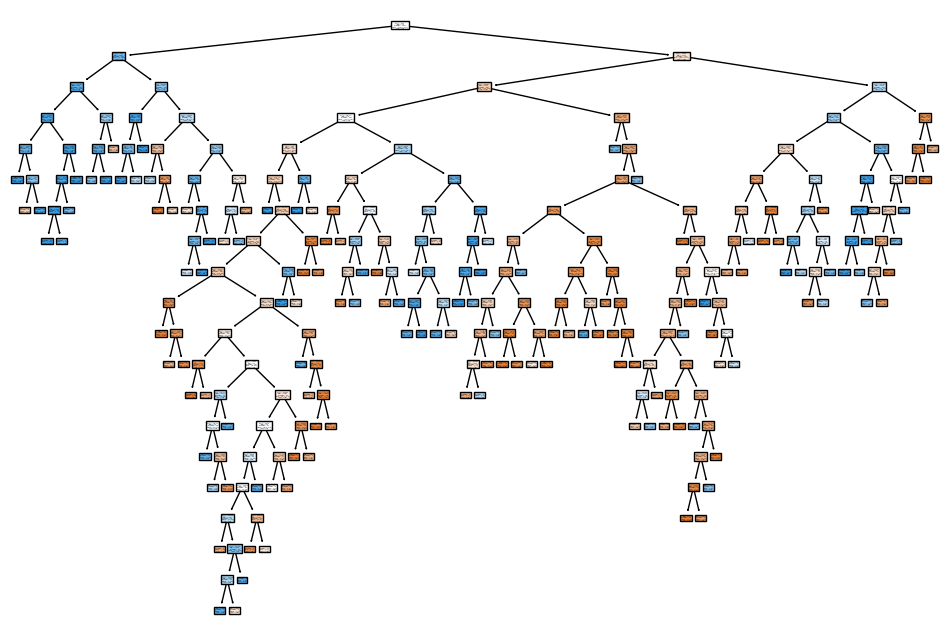

In [115]:
# Train the Decision Tree Classifier.
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=7)
clf.fit(X_train, y_train)

# Predict on the test set and evaluate the model.
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the decision tree.
plt.figure(figsize=(12, 8))

# For plotting, combine feature names for numeric and dummy variables.
numeric_feature_names = X_numeric.columns.tolist()
#categorical_feature_names = encoded_cats.columns.tolist()
#feature_names = numeric_feature_names + categorical_feature_names

plot_tree(clf, class_names=clf.classes_, filled=True)
plt.show()

#print("Columns used in the model:" + numeric_feature_names)

columns_of_interest = ['DAMAGE_PROPERTY', 'LAT', 'LON', 'ELAPSED_TIME_MIN', 'TOR_F_SCALE', 'MAGNITUDE', 'TOR_LENGTH', 'TOR_WIDTH']
#correlation_matrix = df[columns_of_interest].corr()




# Most association with different features

# Decision Tree Regressor

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# --- Prepare Features and Target --- #
# Select numeric columns for features
numeric_columns = df.select_dtypes(include=[np.number]).columns
X = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS']).values  # Features
y = df['DAMAGE_PROPERTY'].values  # Target variable (continuous)

# Handle missing values in X
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Ensure there are no missing values in y
df = df.dropna(subset=['DAMAGE_PROPERTY'])
y = df['DAMAGE_PROPERTY'].values

# --- Split the Data --- #
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train the Random Forest Regressor --- #
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=42, max_depth=100, min_samples_leaf=10)
rf_regressor.fit(X_train, y_train)

# --- Make Predictions --- #
y_pred = rf_regressor.predict(X_test)

# --- Evaluate the Model --- #
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 6491040101.021969
Mean Absolute Error (MAE): 12542.286189051521
R-squared (R2): 0.04473272291615771


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

# --- Identify Categorical Columns --- #
categorical_columns = ['TOR_F_SCALE']  # Example categorical columns

# One-hot encode categorical columns
encoded_cats = pd.get_dummies(df[categorical_columns], drop_first=True)

# --- Prepare Features and Target --- #
# Select numeric columns and drop irrelevant ones
numeric_columns = df.select_dtypes(include=[np.number]).columns
X_numeric = df[numeric_columns].drop(columns=['DAMAGE_PROPERTY', 'DAMAGE_CROPS'])

bins = [0, 1000, 10000, 100000, np.inf]  # Example bin edges
labels = ['low', 'medium', 'high', 'very high'] 

df['DAMAGE_CATEGORY'] = pd.cut(df['DAMAGE_PROPERTY'], bins=bins, labels=labels, include_lowest=True)

# Combine numeric and encoded categorical features
X_full = pd.concat([X_numeric, encoded_cats], axis=1)

# Target variable
y = df['DAMAGE_CATEGORY'].values

# Handle missing values in X
imputer = SimpleImputer(strategy='median')
X_full = imputer.fit_transform(X_full)

# --- Split the Data --- #
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# --- Train the Random Forest Classifier --- #
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# --- Make Predictions --- #
y_pred = rf_clf.predict(X_test)

# --- Evaluate the Model --- #
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))



# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (Selected Variables)")
plt.show()

Accuracy: 0.8606579786749293
Classification Report:
               precision    recall  f1-score   support

        high       0.47      0.32      0.38       597
         low       0.91      0.96      0.93      9038
      medium       0.57      0.48      0.53      1166
   very high       0.62      0.20      0.30       172

    accuracy                           0.86     10973
   macro avg       0.64      0.49      0.53     10973
weighted avg       0.84      0.86      0.85     10973

